# Credit scoring

In this competition we're provided with:
- train and test datasets of 73,799 and 36,349 samples respectivly and 18 features except target one;
- model that we're not allowed to change;
- baseline that gives **ROC_AUC = 0.672**;
- target variable **default** is binary;
- the bank has more not defaulted clients (87% vs 13%) - **sampling is unbalanced**

Our model is **Logistic Regression**.

What has been done here:
1. **Pipeline** for model that includes:
- OneHotEncoder for binary and categorical features
- Logarithm for some numeric features
2. GridSearchCV for pipeline to find better hyperparameters except C

The best model (without additional default samples): **roc_auc = 0.745, f1_score = 0.3371**

***We still have very pure f1_score. But the key metric is ROC_AUC and it's lower in the model with higher f1_score.***

More details on the features:
- client_id - client ID
- education - level of education
- sex - gender of the borrower
- age - the age of the borrower
- car - car availability flag
- car_type - flag of a foreign car
- decline_app_cnt - the number of rejected past applications
- good_work - flag for having a “good” job
- bki_request_cnt - number of requests in BKI
- home_address - home address categorizer
- work_address - work address categorizer
- income - the borrower's income
- foreign_passport - availability of a foreign passport
- sna - connection of the borrower with the bank's clients
- first_time - the limitation of the availability of information about the borrower
- score_bki - score based on data from the BKI
- region_rating - region rating
- app_date - date of application submission
- default - the default flag on the loan

For data investigation results go to 'Bella K [SF-DST] Credit Scoring EDA&First Model'

For models testing results go to 'Bella K [SF-DST] Credit Scoring Models'

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
import warnings
warnings.simplefilter('ignore')

from pandas import Series

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')  # beautiful graphs
plt.rcParams['figure.figsize'] = (12, 4)  # figure size

import seaborn as sns
%matplotlib inline

import random
from datetime import datetime, timedelta

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, FunctionTransformer, LabelBinarizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [24]:
!pip freeze > requirements.txt

In [3]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [4]:
df_train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [5]:
df_test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [6]:
sample_submission.head()

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


# DATA

In [7]:
print('Train dataset shape:', df_train.shape)
print('Test dataset shape:', df_test.shape)
print('Submission shape:', sample_submission.shape, end='\n\n')
print(f'Test dataset is {round(df_test.shape[0]/(df_test.shape[0]+df_train.shape[0])*100, 2)}% of the whole dataset')
print(f'Submission is {round(sample_submission.shape[0]/df_test.shape[0]*100, 2)}% of test dataset', end='\n\n')
print('Differences in train and test datasets columns:', list(set(df_train.columns) - set(df_test.columns)), end='\n\n')

print('Train dataset:', end='\n\n')
display(pd.value_counts(df_train.dtypes))
print('\n\nTest dataset:', end='\n\n')
display(pd.value_counts(df_test.dtypes))

Train dataset shape: (73799, 19)
Test dataset shape: (36349, 18)
Submission shape: (24354, 2)

Test dataset is 33.0% of the whole dataset
Submission is 67.0% of test dataset

Differences in train and test datasets columns: ['default']

Train dataset:



int64      12
object      6
float64     1
dtype: int64



Test dataset:



int64      11
object      6
float64     1
dtype: int64

In [8]:
df_train.default.unique()

array([0, 1])

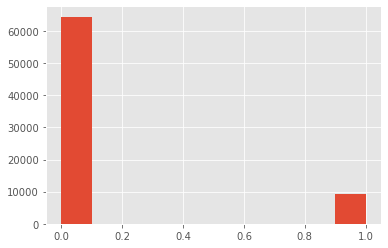

In [9]:
# look at which customers the bank has more: defaulted (1) or not (0)
df_train.default.hist()

In [10]:
df_train.default.value_counts(normalize=True)

0    0.873006
1    0.126994
Name: default, dtype: float64

1. Target variable **default** is binary.
2. Bank has more not defaulted clients (87% vs 13%) - sampling is unbalanced

In [11]:
df_train.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')

## Preprocessing

In [12]:
# Data
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

df_train['sample'] = 1
df_test['sample'] = 0
df_test['default'] = -1

df = df_test.append(df_train, sort=False).reset_index(drop=True)


# NaNs
df['education'].fillna(df['foreign_passport'].map({'Y': 'GRD', 'N': 'UGR'}), inplace=True)
df['education'] = df['education'].map({'SCH': 1, 'UGR': 2, 'GRD': 3, 'PGR': 4, 'ACD': 5})


# Date
df['app_date'] = df['app_date'].dropna().apply(lambda x: pd.to_datetime(x))
max_date = max(df.query('sample==1').app_date)
df['app_date_max_dlt'] = df['app_date'].dropna().apply(lambda x: (max_date - x).days)
df['app_date_day'] = df['app_date'].dropna().apply(lambda x: x.day)
df['app_date_month'] = df['app_date'].dropna().apply(lambda x: x.month)
df['app_date_dow'] = df['app_date'].dropna().apply(lambda x: x.dayofweek)
df['app_date_w_end'] = df['app_date_dow'].dropna().apply(lambda x: 1 if x in [5, 6] else 0)


# Columns
bin_features = [col for col in list(df.columns) if df[col].nunique()==2 and col!='sample'] # default (target)
cat_features = [col for col in list(df.columns) if df[col].nunique()>2 and df[col].nunique()<11 and col!='default']
log_features = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
num_features = [col for col in list(df.columns) if df[col].nunique()>10 and col not in ['client_id','app_date']]
num_features = list(set(num_features) - set(log_features))


# X, y
X = df.query('sample==1').copy().drop(['client_id', 'app_date', 'default', 'sample'], axis=1)
y = df.query('sample==1')['default'].copy()

X_test = df.query('sample==0').copy().drop(['client_id', 'app_date', 'default', 'sample'], axis=1)
y_test = df.query('sample==0')['default'].copy()


# Model

In [13]:
def get_roc_auc(X, y, model):
    y_pred_prob = model.predict_proba(X)[:,1]
    y_pred = model.predict(X)

    fpr, tpr, threshold = roc_curve(y, y_pred_prob)
    roc_auc = roc_auc_score(y, y_pred_prob)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    
    print('F1: %.4f' % f1_score(y, y_pred))
    
    conf_mat = pd.DataFrame(confusion_matrix(y, y_pred).T)
    display(conf_mat)
    
    conf_mat = confusion_matrix(y, y_pred).T
    TN, FN, FP, TP = conf_mat[0][0], conf_mat[0][1], conf_mat[1][0], conf_mat[1][1]
    print('Precision', round(precision_score(y, y_pred), 3))
    print('Recall', round(recall_score(y, y_pred), 3))
    print('TP Rate', round(TP / (TP + FN), 3))
    print('FP Rate', round(FP / (TN + FP), 3))
    

    
from sklearn.model_selection import cross_validate

def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] f1_score = {:.4f} +/- {:.4f}'.format(avg_f1_train, std_f1_train))
    print('[valid] f1_score = {:.4f} +/- {:.4f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('f1_score', fontsize=15)
    plt.legend(fontsize=15)
    

The share of positive results among "bad" borrowers (truly positive results) is the sensitivity of the model, that is, the ability of the model to correctly identify "bad" borrowers and minimize losses associated with issuing a loan to a "bad" client.

The proportion of negative results among "good" borrowers (truly negative results) is the specificity of the model (Specificity). Here we are already talking about the ability of the model to correctly identify "good" borrowers and minimize losses associated with the refusal to issue a loan to a bona fide client.

The F1 score is a metric commonly used in classification tasks to evaluate the model's performance. It combines precision and recall into a single value, providing a balanced measure of the model's accuracy.

The F1 score is calculated based on the precision (P) and recall (R) values, which are defined as follows:

Precision (P) = True Positives / (True Positives + False Positives) - Defaults

Recall (R) = True Positives / (True Positives + False Negatives)

The F1 score is then computed as the harmonic mean of precision and recall:

F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

The F1 score ranges between 0 and 1, with 1 being the best possible value. A higher F1 score indicates better model performance in terms of both precision and recall.

When interpreting the F1 score, consider the following:
1. Balance between Precision and Recall: The F1 score gives equal weight to precision and recall, which means it provides a balanced assessment of the model's performance in terms of correctly identifying positive instances (precision) and capturing all positive instances (recall).
2. Higher is Better: A higher F1 score indicates better model performance. A score of 1 means perfect precision and recall, while a score close to 0 indicates poor performance.
3. Task-dependent Interpretation: The interpretation of the F1 score may vary depending on the specific classification task and its requirements. For example, in a medical diagnosis scenario, where false negatives (missed positive cases) are more critical, a higher recall (and thus, a higher F1 score) might be more desirable.
4. Compare F1 scores: When comparing different models or configurations, it's helpful to look at their respective F1 scores. The model with a higher F1 score is generally considered to have better overall performance.

In summary, the F1 score provides a balanced assessment of a classification model's performance by considering both precision and recall. It's a useful metric for evaluating and comparing models, especially when the dataset is imbalanced or when false positives and false negatives have different levels of impact in the specific task.


In [14]:
class MySelector(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.cols].values


# Pipeline
bin_pipe = Pipeline([
  ('select_bin', MySelector(cols=bin_features)),
  ('binarize', OneHotEncoder(sparse = False)) # LabelBinarizer()
  ])

cat_pipe = Pipeline([
  ('select_cat', MySelector(cols=cat_features)),
  ('encoder', OneHotEncoder(sparse = False))
  ])

log_pipe = Pipeline([
  ('select_log', MySelector(cols=log_features)),
  ('transformer', FunctionTransformer(np.log1p, validate=False)) # Return the natural logarithm of one plus the input array, element-wise.
  ])

num_pipe = Pipeline([
  ('select_num', MySelector(cols=num_features))
  ])

full_pipeline = Pipeline([
    ('feat_union', FeatureUnion(transformer_list=[
          ('bin_pipeline', bin_pipe),
          ('num_pipeline', num_pipe),
          ('log_pipeline', log_pipe),
          ('cat_pipeline', cat_pipe)
          ])),
    ('classify', LogisticRegression())
    ])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('feat_union',
                 FeatureUnion(transformer_list=[('bin_pipeline',
                                                 Pipeline(steps=[('select_bin',
                                                                  MySelector(cols=['sex',
                                                                                   'car',
                                                                                   'car_type',
                                                                                   'good_work',
                                                                                   'foreign_passport',
                                                                                   'app_date_w_end'])),
                                                                 ('binarize',
                                                                  OneHotEncoder(sparse=False))])),
                                                ('num_pipeline',
    

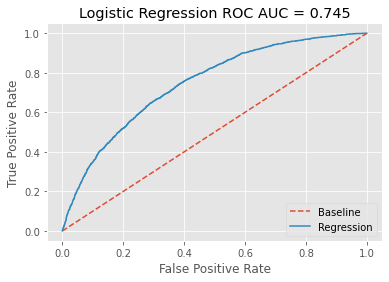

F1: 0.0464


,0,1
0,12867,1782
1,66,45


Precision 0.405
Recall 0.025
TP Rate 0.025
FP Rate 0.005


In [15]:
get_roc_auc(X_valid, y_valid, full_pipeline)

## Hyperparameters

In [16]:
def classification_report(y_valid, y_pred):
    
    # print parameters
    for param_name in sorted(gridsearch.best_params_.keys()):
            print('\t%s: %r' % (param_name, gridsearch.best_params_[param_name]))

In [17]:
iter_ = 50
epsilon_stop = 1e-3
C=0.005994842503189409

param_grid = [
    {'classify': [LogisticRegression(random_state=42)], 
     'classify__C': [C],
     'classify__penalty': ['l1'], 
     'classify__solver': ['liblinear' 'saga'], 
     'classify__class_weight': ['none', 'balanced'], 
     'classify__multi_class': ['auto','ovr'], 
     'classify__max_iter': [iter_],
     'classify__tol': [epsilon_stop]},
    {'classify': [LogisticRegression(random_state=42)],
     'classify__C': [C],
     'classify__penalty': ['l2'], 
     'classify__solver': ['newton-cg', 'lbfgs', 'liblinear', 'newton-cholesky', 'sag', 'saga'], 
     'classify__class_weight': ['none', 'balanced'], 
     'classify__multi_class': ['auto','ovr'], 
     'classify__max_iter': [iter_],
     'classify__tol': [epsilon_stop]},
    {'classify': [LogisticRegression(random_state=42)],
     'classify__C': [C],
     'classify__penalty': ['elasticnet'], 
     'classify__solver': ['saga'], 
     'classify__class_weight': ['none', 'balanced'], 
     'classify__multi_class': ['auto','ovr'], 
     'classify__max_iter': [iter_],
     'classify__tol': [epsilon_stop]},
    {'classify': [LogisticRegression(random_state=42)],
     'classify__C': [C],
     'classify__penalty': ['none'], 
     'classify__solver': ['newton-cg', 'lbfgs'], 
     'classify__class_weight':['none', 'balanced'], 
     'classify__multi_class': ['auto','ovr'], 
     'classify__max_iter':[iter_],
     'classify__tol':[epsilon_stop]},
]

gridsearch = GridSearchCV(full_pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)

best_model = gridsearch.best_estimator_

y_pred = best_model.predict(X_valid)

for param_name in sorted(gridsearch.best_params_.keys()):
    print('\t%s: %r' % (param_name, gridsearch.best_params_[param_name]))

	classify: LogisticRegression(C=0.005994842503189409, class_weight='balanced', max_iter=50,
                   penalty='none', random_state=42, solver='newton-cg',
                   tol=0.001)
	classify__C: 0.005994842503189409
	classify__class_weight: 'balanced'
	classify__max_iter: 50
	classify__multi_class: 'auto'
	classify__penalty: 'none'
	classify__solver: 'newton-cg'
	classify__tol: 0.001


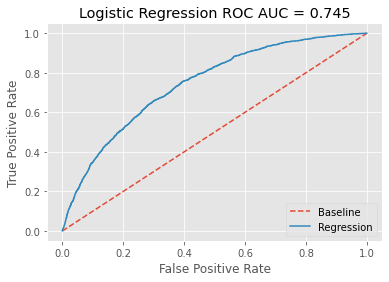

F1: 0.3371


,0,1
0,8638,586
1,4295,1241


Precision 0.224
Recall 0.679
TP Rate 0.679
FP Rate 0.332


In [18]:
get_roc_auc(X_valid, y_valid, best_model)

In [19]:
import pickle

with open('/kaggle/working/credit_scoring_best_model.pkl', 'wb') as output:
       pickle.dump(best_model, output)

# Submission

In [20]:
# Переносим модель на тестовые данные

y_pred_prob_def = best_model.predict_proba(X_test)[:,1]
y_pred_def = best_model.predict(X_test)
display(y_pred_prob_def[:5])
display(y_pred_def[:5])
display(y_pred_prob_def.shape)
display(y_pred_def.shape)

array([0.22205005, 0.77147937, 0.32204763, 0.40670173, 0.14302788])

array([0, 1, 0, 0, 0])

(36349,)

(36349,)

In [21]:
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [22]:
# Формируем submission
submission_test = pd.DataFrame(df_test['client_id'],
                               columns = ['client_id'])
submission_test['default'] = 0
submission_test['default'] = y_pred_prob_def
display(submission_test.head())
display(submission_test.info())

,client_id,default
0,74835,0.222050
1,17527,0.771479
2,75683,0.322048
3,26883,0.406702
4,28862,0.143028


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  36349 non-null  int64  
 1   default    36349 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 568.1 KB


None

In [23]:
submission_test.to_csv('submission.csv', index=False)
submission_test.head()

,client_id,default
0,74835,0.222050
1,17527,0.771479
2,75683,0.322048
3,26883,0.406702
4,28862,0.143028
